In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Introduction


### The problem
The <a href="http://www.start.umd.edu/gtd/">Global Terrorism Database</a> is a database of all 180,691 reliably recorded acts of terror since 1970.  The data has been collected, cleaned, and curated with the help of various grants and currently resides at the University of Maryland.  In this project, I'll be trying to attribute responsibility for the 46% of these acts of terrorism that are currently unattributed.

This problem presents a number of challenges: 
- the dataset is large, many-featured and strewn with nulls (requires extensive cleaning)
- the data is mixed-type with some categorical and even unstructured data
- the training set of attributed acts differs from the real, untestable test set of unattributed data

But there's one problem in particular that will define this project: there are 3536 distinct categorical values of the target feature.  This places constraints on both our accuracy and our computational feasibility.

### Approaches
My first steps here will be some pretty extensive data cleaning, data examination, and preliminary feature engineering.  After that, I'll explore several different strategies for building a model.  

The ideal approach to a problem with this many target categories would be hierarchical classification, in which a series of submodels are trained to predict successive levels of a hierarchical classification of the target feature (e.g., schools, then departments, then courses), with each prediction utilizing the previous (higher-level) set of predictions.  This sort of model has several advantages.  For one thing, it can achieve increased accuracy and decreased computational cost, since each model only has to predict among the subclasses of the subcategory it is operating on (similar in principle to binary search).  For another, it allows increased transparency: the user can view the successive levels of an example's classification, and the model can even leave an example's classification short of the most specific level if the confidence level is too low.

This case is missing one usual ingredient for such a scheme, though: we don't a hierarchical classification for the terror-perpetrating groups in this dataset. It would be possible to build one from existing incident features, but this would amount to just feature-segmented prediction.  Ideally, we would do extensive research to catalogue the size, ideology, history, nationality, and funding sources of each group.  But this would take more time than I can afford.

Fortunately, there are a number of ways to approximate this approach.  First, I'll try flat classification (no tiering) on subsets of the data as a benchmark.  Then I'll try four different hierarchical or segmented approaches:
1. <b>frequency-based segmented classification:</b> Train a classifier to predict the frequency tier of the data (top 20 most prolific groups, top 50, etc).  Segment the test examples accordingly and train a model on each segment.  The models should be able to achieve a high degree of accuracy on the higher tiers, and parameters can be tweaked to squeeze the most out of the lower tiers (which comprise a small minority of the total data).
2. <b>feature-based segmented classification:</b> Use the same principle, but this time segment the data based on region of the world, and perhaps a time segment as well (smaller clusters of countriers could also be used).  Attacks in Sub-Saharan Africa will only have to be classified among groups with recorded attacks in Sub-Saharan Africa.  This should reduce the number of categories for each predictor by an average 90%.
3. <b>cluster-based hierarchical classification:</b> Group the data by attributed group to generate a profile for each group.  Cluster the groups (probably KNN, Ward agglomerative, or HDBSCAN).  Train a first model to first predict the cluster label of the group.  Then train a second to predict the group from within the groups of that cluster label.  Multiply the probability of the second model by the probability of the first to get an accurate overall probability.  This can be used recursively (ideally with a hierarchical clustering like Ward or HDBSCAN) to produce a multi-tiered hierarchical classification model.
4. <b>quasi-hierarchical (boosted) classification:</b> Run frequency-tier prediction and one or more clustering methods on the data.  Include predicted frequency tier and predicted cluster label(s) as features (a form of boosting).  Let the main classification algorithm sort out how to use these in conjunction with the original features.

Any of these algorithms could prove quite effective.  The frequency-based and quasi-hierarchical options (#1 and #4) will probably be the simplest to implement.  It's hard to predict ahead of time which will be more effective - which is why we need to try at least a sketch of all four.

Each of these approaches can be executed using a variety of classification models.  Given the size and nature of the data, though, the models will need to be non-linear and pretty fast/scalable.  Ability to handle nulls directly is also a plus.  Based on these criteria, the main models I'll use will be:
- <b>Naive Bayes:</b> Simple, fast, and non-linear. But this comes with downsides: not all these features are independent, and they have different types of distributions (frustratingly, slkearn doesn't allow mixed-distribution NB classifiers, so you have to assemble them yourself, which is a little complicated).
- <b>KNN Classifier:</b> Also simple, fast, and non-linear.  I doubt this will be as accurate, but given that I'll be trying clustering anyway, it seems worth a quick try.
- <b>Decision tree:</b> Simple, fast, and non-linear - but prone to overfitting.  There are some ways to counteract this, though, and it's highly interpretable.  A natural conceptual fit with hierarchical classification.
- <b>LightGBM:</b> This model is not as simple as the others, but it's non-linear, highly optimized, and generally very accurate.  It's a gradient-boosted-tree model similar to xgboost (or the very recent catboost), but it tends to run almost twice as fast due to selecting features for splits by node rather than by level.  (It's also a convenient choice because it's the model I've worked the most with.)

An SVM could also be effective for accuracy, but it is far, far slower than the models listed above.  In my limited experience, it's also frequently outperformed by boosted tree models like xgboost or lightGBM.  A neural net also might prove useful here, especially for trying one-shot learning on the long tail of singleton classes (groups responsible for only one incident).  But the hierarchical nature of the data points toward tree-based models, and I'm not yet as adept with NN construction, tweaking, and interpretation as I am with tree-based models.

### Evaluation
Throughout this project I'll mostly be using plain old accuracy for my evaluation metric.  In a case of multiclass but non-multilabel classification like this, accuracy doesn't have the normal class-imbalance drawbacks: in fact, it's precisely identical to f1-score, either micro or macro (every false positive for one category is a false negative for another).  If time allows, it may also be worth looking at a multiclass-modified AUROC score.  Similar to clustering, though, we can also check consistency of results across different train/test splits of the data: a more consistent model is more likely to be finding real 

### Goals
It's hard to set a preliminary accuracy goal for a new sort of problem like this - especially since there's no way to truly check accuracy for our predictions for the unattributed incidents in the dataset.  We can at least test consistency, though: so one of my goals will be to create a stable and consistent predictive model over the unattributed incidents.  <a href="https://www.researchgate.net/publication/268445148_Terrorist_Group_Prediction_Using_Data_Classification">A 2014 paper published over this dataset</a> using an ensemble method was able to achieve a 6.64% error rate, so it would be ideal to get my CV accuracy at least to 90%, and hopefully close to 95%.  

That said, there are bound to be various hitches here since this is my first run at hierarchical classification.  That also means that one of my main goals (as usual) is to learn from the project and try a few new ideas.  

### Limitations
My main caveat here, beyond the evaluation limitations of an unlabeled test set and my inexperience with hierarchical classification, is that I'm running on very limited time.  (For most of the time I would have been working on this challenge problem, I've been helping my brother drive his family's furniture etc. acroos the country in a moving truck.)  So this notebook won't reach its full completion, and some parts will still be pseudocode by the end.

However, in conjunction with the plan outlined above, the material here should give you a pretty accurate picture of both my general M.O. and where the project is headed.  And I'll tinker with the project (as time allows) for curiosity's sake after the deadline, so if you're interested enough to hold an interview, I should have at least a few more answers by then.

<b>Note:</b> the custom categorical Naive Bayes package I wrote for this project (included in the parent directory here) may be of interest, even though it didn't turn out to be especially useful on the project at hand.  I'm hoping to combine it later with sklearn-like Bernoulli, Gaussian, and Poisson NB classifiers to create a true mixed-type Naive Bayes classifier.


# Load and clean

In [2]:
gtd_raw_df = pd.read_csv('globalterrorismdb_0718dist.csv', low_memory=False)

In [3]:
gtd_raw_df.shape

(181691, 135)

In [9]:
gtd_raw_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [15]:
gtd_raw_df.dtypes.value_counts()

object     58
float64    55
int64      22
dtype: int64

In [ ]:
# output cleared for sake of reader
print('OVER HALF NULLS:')
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if null_counts[col] > 100000:
        print(col + ":", null_counts[col])

print('\nMANY NULLS:')
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if 100000 >= null_counts[col] > 5000:
        print(col + ":", null_counts[col])

print('\nA FEW NULLS:')        
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if 5000 >= null_counts[col] > 0:
        print(col + ":", null_counts[col])
        
print('\nNO NULLS:')        
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if null_counts[col] == 0:
        print(col)

First we'll do the general-purpose cleaning:

In [13]:
gtd_df = gtd_raw_df.copy()

# drop the 6 rows with 'specificity' nulls - these should be impossible, since 'unknown' is included
gtd_df.dropna(subset=['specificity'], inplace=True)

# 'compclaim' is corrupted: despite having 'no' and 'unknown' options, it's overwhelmingly null with no explanation
gtd_df.drop('compclaim', axis=1, inplace=True)

# for some columns, -9 purely indicates 'unknown' and is precisely the same as Nan
gtd_df['claimed'] = gtd_df.claimed.replace(-9, np.nan)
gtd_df['ransom'] = gtd_df.ransom.replace(-9, np.nan)
gtd_df['ishostkid'] = gtd_df.ishostkid.replace(-9, np.nan)
gtd_df['doubtterr'] = gtd_df.doubtterr.replace(-9, np.nan)
gtd_df['nperps'] = gtd_df.nperps.replace(-99, np.nan)
gtd_df['nperpcap'] = gtd_df.nperpcap.replace(-99, np.nan)

# 20 unknown months are entered as 0s
gtd_df['imonth'] = gtd_df.imonth.replace(0, np.nan)

# drop numerical category codes for categorical string variables (redundant)
numerical_codes = [
    'natlty1',
    'country',
    'attacktype1',
    'attacktype2',
    'attacktype3',
    'targtype1',
    'targtype2',
    'targtype3',
    'targsubtype1',
    'targsubtype2',
    'targsubtype3',
    'weaptype1',
    'weaptype2',
    'weaptype3',
    'weaptype4',
    'weapsubtype1',
    'weapsubtype2',
    'weapsubtype3',
    'weapsubtype4',
    'alternative',
    'hostkidoutcome',
    'propextent',
    'claimmode'
]
gtd_df.drop(numerical_codes, axis=1, inplace=True)

# add total_null_ct column (done after the above so num-coded categorical features aren't counted twice)
gtd_df['total_null_ct'] = gtd_df.isnull().sum(axis=1)

# since there are no iyear nulls, and only 20 imonth nulls, and day of month won't likely be useful,
# we can drop approxdate altogether:
gtd_df.drop('approxdate', axis=1, inplace=True)

# fill nulls in alternative_txt (coded alt explanation, e.g. State Actors, for doubted cases)
# with new category 'None'
gtd_df['alternative_txt'] = gtd_df['alternative_txt'].fillna('None')

# for instances with no longitude or latitude, read in the central longitude and latitude 
# of the country of occurrence (from an external datasheet), but flag as approximate
gtd_df['coordinates_are_approx'] = gtd_df.longitude.isnull()
coordinates_df = pd.read_csv('country_coordinates2.csv')[['name','latitude','longitude']]
coordinates_df.rename(columns={'name':'country_txt','latitude':'latitude2','longitude':'longitude2'}, inplace=True)
gtd_df = gtd_df.merge(coordinates_df, on='country_txt', how='left')
gtd_df['longitude'] = gtd_df.longitude.fillna(gtd_df.longitude2)
gtd_df['latitude'] = gtd_df.latitude.fillna(gtd_df.latitude2)
gtd_df.drop(['latitude2', 'longitude2'], axis=1, inplace=True)
# for reasons unclear, the one 'St. Kitts and Nevis' null won't fill even when the name is directly copied and pasted
# into this spreadsheet.  We'll manually fill it here:
gtd_df.at[59662,'latitude'] = 17.357822
gtd_df.at[59662,'longitude'] = -62.783998
gtd_df.isnull().sum().sum()

# boolean-ize and drop columns that are overwhelmingly null and have many categories:
gtd_df['has_second_attacktype'] = ~gtd_df.attacktype2_txt.isnull()
gtd_df['is_related'] = ~gtd_df.related.isnull()
gtd_df.drop(['related','attacktype2_txt', 'attacktype3_txt'], axis=1, inplace=True)

# combine nhours and ndays of hostage situation
gtd_df['nhours'] = gtd_df.nhours + gtd_df.ndays*24
gtd_df.drop('ndays', axis=1, inplace=True)

# convert hostages released to hostages unreleased so that we can fill with 0:
gtd_df['n_unreleased'] = gtd_df['nhostkid'] - gtd_df['nreleased']
gtd_df.drop('nreleased', axis=1, inplace=True)

# fill 0 for hostage-related numbers where no hostages taken
hostage_num_cols = [
    'nhours',
    'nhostkid',
    'nhostkidus',
    'ransomamt',
    'ransomamtus',
    'ransompaid',
    'ransompaidus',
    'n_unreleased'
]
gtd_df[hostage_num_cols] = gtd_df[hostage_num_cols].fillna(0)

# drop sparse & unhelpful secondary / tertiary claim info - which is almost entirely null:
empty_cols = [
    'claim2',
    'claimmode2',
    'claim3',
    'claimmode3',
    'natlty2',
    'natlty3',
    'guncertain2',
    'guncertain3'
]
gtd_df.drop(empty_cols, axis=1, inplace=True)

# fill 'none' for categorical extent of property damage (includes 'unknown' already; blanks are for no damage)
gtd_df['propextent_txt'] = gtd_df['propextent_txt'].fillna('none')

# for now we'll also drop string 'resolution' (date of resolution of extended incident) because it's a unique-valued
# string; we could later convert it to a number-of-days interval
gtd_df.drop('resolution', axis=1, inplace=True)

# drop all other string columns with null counts > 100K, with a few exceptions
significant_though_null_cols = ['motive', 'location', 'propcomment', 'resolution']
for col in gtd_df.select_dtypes('object').columns:
    if gtd_df[col].isnull().sum() > 100000 and col not in significant_though_null_cols:
        gtd_df.drop(col, axis=1, inplace=True)
        
# fix a single wild longitude error   
if gtd_df.loc[17658, 'longitude'] != -86185896.0:
    print("WARNING: index has changed.  Transform longitude for eventid 198212240004")
# accessed by index because pandas won't let you change data by boolean accessing
gtd_df.loc[17658, 'longitude'] = gtd_df.loc[17658, 'longitude'] / -10e5

Then we'll do some additional cleaning for modeling purposes:

In [16]:
gtd_prepped_df = gtd_df.copy()

# *** DEALING WITH TEXT COLUMNS ***

# drop the following columns because they're long strings (unique, not categories)
# we'll save them in a separate df for later feature engineering
text_cols = [
    'summary', #  textual summary of event
    'motive', # reported motive of attack
    'weapdetail',  # additional notes on weapon
    'location', # additional notes on location
    'target1', # name of target
    'scite1', # source citation 1
    'propcomment'
]
text_df = gtd_prepped_df[text_cols]
gtd_prepped_df.drop(text_cols, axis=1, inplace=True)

# *** DEALING WITH HYPERSPECIFIC CATEGORICAL COLUMNS ***

# list categorical columns with too many distinct values for dummying (ranging 100-3000 vals)
# NOTE: 'country_txt' at 205 distinct values, is excepted because of its obvious importance
hyperspecific_cols = [
    'natlty1_txt',      # 210 distinct values, but almost entirely identical to 'country_txt'
    'provstate',        # useful, but 2855 distinct values
    'city',             # useful, but 36672 distinct values
    'targsubtype1_txt', # 112 distinct values, with dwindling tail of value counts
]
# fill their nulls with 'unknown'
for col in hyperspecific_cols:
    gtd_prepped_df[col] = gtd_prepped_df[col].fillna('Unknown')
    
# convert hyperspecific features to the X most common values (X determined by manual dropoff-analysis) or 'other'
def top_n_cats(series, n=10, keep_nulls=False):
    top_n = series.value_counts().index[:n]
    if keep_nulls:
        top_n = list(top_n) + [np.nan]
    return pd.Series([val if val in top_n else 'other' for val in series])   

hyperspecific_tups = [
    ('provstate', 15),
    ('city', 15),
    ('targsubtype1_txt', 20)
]

for tup in hyperspecific_tups:
    gtd_prepped_df[tup[0]+'_common'] = top_n_cats(gtd_prepped_df[tup[0]], n=tup[1])

# we'll save the original columns for later feature engineering etc. before dropping them
hyperspecific_df = gtd_prepped_df[hyperspecific_cols + ['gname']].copy()
gtd_prepped_df.drop(hyperspecific_cols, axis=1, inplace=True)

# *** OTHER MISCELLANEOUS ***

# fill 'weapsubtype1_txt' with 'Unknown' (only 30 categories, so no need to commonize)
gtd_prepped_df['weapsubtype1_txt'] = gtd_prepped_df['weapsubtype1_txt'].fillna('Unknown')

# 'corp1' for name of target org. is like the above columns, but it's alread encapsulated by 'targsubtype1'
# so we'll just drop it
hyperspecific_df['corp1'] = gtd_prepped_df['corp1']
gtd_prepped_df.drop('corp1', axis=1, inplace=True)

And finally, we'll do some additional imputing to create a null-less version of our data (necessary for algorithms like sklearn's that can't handle nulls):

In [17]:
gtd_filled_df = gtd_prepped_df.copy()

gtd_filled_df['imonth'] = gtd_filled_df['nkill'].fillna(0)

# fill 'guncertain' with 1 (means attributed group isn't a certain attribution)
gtd_filled_df['guncertain1'] = gtd_filled_df['guncertain1'].fillna(1)

# median-impute casualties - they're only left blank if there is evidence of some,
# (so it's non-zero), but there's insufficient evidence to give a number
casualty_cols = [
    'nkill',
    'nkillus',
    'nkillter',
    'nwound',
    'nwoundus',
    'nwoundte'
]
for col in casualty_cols:
    gtd_filled_df[col] = gtd_filled_df[col].fillna(gtd_filled_df[gtd_filled_df[col] > 0][col].median())

# fill flags with 0 where unmarked probably means no:
flag_vars = ['multiple', 'claimed', 'ransom', 'doubtterr', 'ishostkid']
gtd_filled_df[flag_vars] = gtd_filled_df[flag_vars].fillna(0)

# fill propvalue with median prop damage for cases where there was prop damage
gtd_filled_df['propvalue'] = gtd_filled_df['propvalue'].fillna(gtd_filled_df[gtd_filled_df.propvalue > 0].propvalue.median())
gtd_filled_df['propvalue'] = gtd_filled_df['propvalue'] * gtd_filled_df['property'].replace(-9, 0)

# num perpetrators would be useful, but it's overwhelmingly null and there's no good way to impute
gtd_filled_df.drop(['nperps', 'nperpcap'], axis=1, inplace=True)

# confirm that we have no nulls whatsoever remaining:
gtd_filled_df.isnull().sum().sum()

0

The upshot of all this is that we now have five dataframes to work with:
- `gtd_df`: our primary, cleaned-up dataframe (70 columns)
- `gtd_prepped_df`: a version of the main dataframe prepped for general modeling purposes (60 columns)
- `gtd_filled_df`: a version of the prepped dataframe with all nulls imputed or feature-dropped (58 columns)
- `text_df`: columns with long, unique text content for later processing (8 columns)
- `hyperspecific_df`: columns with too many categories for dummying that could be of use later (3 columns)

Note that all of these versions have the same number of examples in the same order.  This means that we can easily feature-engineer and concatenate later as needed.

# Exploring the Data

We'll begin by investigating some basic statistics and plots for our data, with particular attention to our target variable `gname` (the name of the group that perpetrated the attack). We'll begin with general investigation, and then move on to noting differences between the attributed and unattributed attacks.

### Basic stats

In [19]:
all_groups = gtd_df.gname.value_counts().index[1:] # starting at 1 omits 'Unknown'
num_groups = len(all_groups)
num_singletons = sum(gtd_df.gname.value_counts()==1)
singleton_groups = all_groups[-num_singletons:]
non_singleton_groups = all_groups[:num_singletons]

# calculate number of attacks where we don't know the perpetrating group
pct_unattributed = round(sum( gtd_df.gname=='Unknown') / len(gtd_df.gname) *100)

print("Number of total groups:", num_groups) # -1 because 'Unknown' is a category
print("Number of groups with only one attributed attack:", num_singletons)
print("Number of groups with at least two attributed attacks:", sum(gtd_df.gname.value_counts()>1) -1)
print("Number of groups with at least ten attributed attacks:", sum(gtd_df.gname.value_counts()>9) -1)
print("\nNumber of unattributed attacks:", 
      sum(gtd_df.gname=='Unknown'), 
      "({}% of dataset)".format(pct_unattributed) )

Number of total groups: 3536
Number of groups with only one attributed attack: 1711
Number of groups with at least two attributed attacks: 1825
Number of groups with at least ten attributed attacks: 591

Number of unattributed attacks: 82780 (46% of dataset)


In [20]:
print(gtd_df.gname.value_counts()[1:11])

Taliban                                             7477
Islamic State of Iraq and the Levant (ISIL)         5613
Shining Path (SL)                                   4555
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          3287
New People's Army (NPA)                             2772
Irish Republican Army (IRA)                         2671
Revolutionary Armed Forces of Colombia (FARC)       2487
Boko Haram                                          2418
Kurdistan Workers' Party (PKK)                      2310
Name: gname, dtype: int64


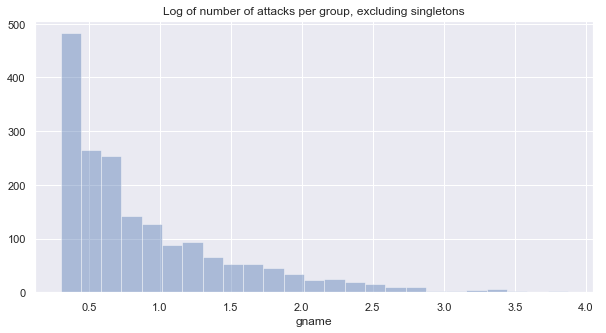

In [6]:
plt.figure(figsize=(10,5))
sns.distplot(np.log10(gtd_df.gname.value_counts()[1:1826]), kde=False)
plt.title("Log of number of attacks per group, excluding singletons")
plt.show()

We can see here that the prolificity of groups (how many attacks each perpetrates) drops off very steeply: even the log distribution looks like an exponential (or possibly Poisson) distribution.  The 30 most prolific grouups (0.8% of all groups) perpetrated over half of the attributed attacks.  Practically, this indicates that a majority of attacks may be fairly easy to attribute (since they belong to the prolific minority), but the long tail of attacks by non-prolific groups will be extremely difficult.

### General plots

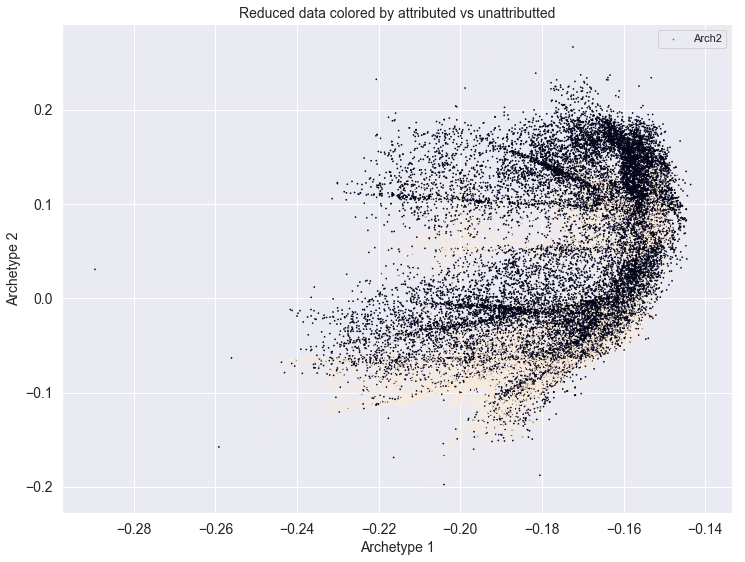

In [24]:
# reload feature-reduced data (method shown later in the notebook)
glrm_vis_df = pd.read_csv('glrm_vis.csv', index_col=0)
plot_df = pd.concat([glrm_vis_df, gtd_df.gname=='Unknown'], axis=1).sample(frac=0.3)
plot_df = plot_df[plot_df.Arch1>-0.3] # cuts off seven or eight outliers for sake of zoom

plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

plt.figure(figsize=(12,9))
plt.scatter(plot_df.Arch1, plot_df.Arch2, c=plot_df.gname, s=0.5)
plt.xlabel('Archetype 1')
plt.ylabel('Archetype 2')
plt.title('Reduced data colored by attributed vs unattributted')
plt.legend()
plt.show()

We can see here that while this data displays no clear and obvious clusters or linearity, it contains definite patterns.  There are also some perceptible differences between attributed and unattributed incidents.

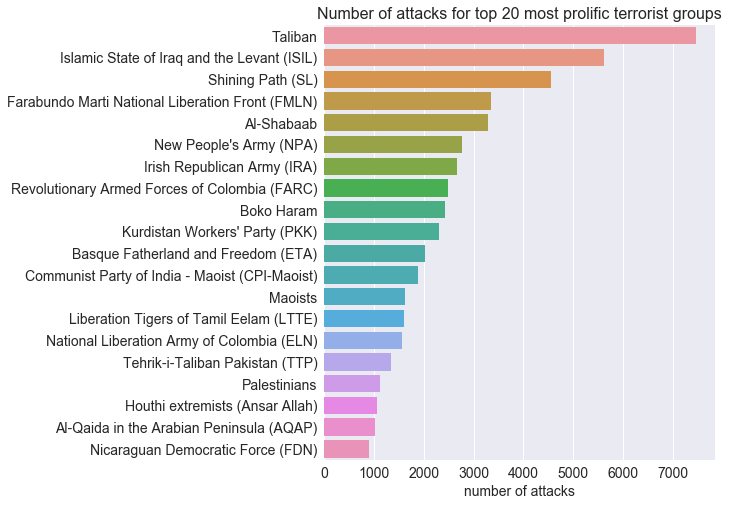

In [107]:
plt.rc('axes', titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

plt.figure(figsize=(7,8))
y = gtd_df.gname.value_counts().index[1:21]
x = gtd_df.gname.value_counts()[1:21]
sns.barplot(x, y)
plt.xlabel('number of attacks')
plt.title("Number of attacks for top 20 most prolific terrorist groups")
plt.show()

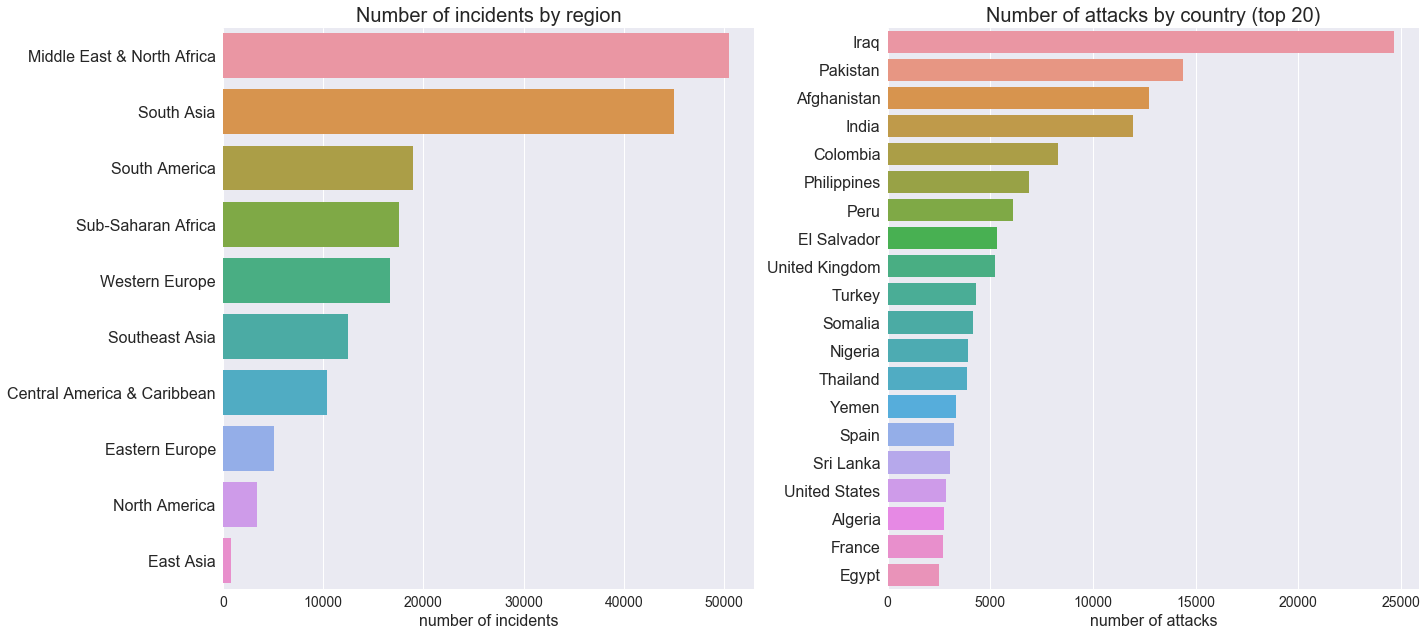

In [110]:
plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(20,9))

plt.subplot(121)
y = gtd_df.region_txt.value_counts().index[:10]
x = gtd_df.region_txt.value_counts()[:10]
sns.barplot(x, y)
plt.xlabel("number of incidents")
plt.title("Number of incidents by region")

plt.subplot(122)
y = gtd_df.country_txt.value_counts().index[:20]
x = gtd_df.country_txt.value_counts()[:20]
sns.barplot(x, y)
plt.xlabel('number of attacks')
plt.title("Number of attacks by country (top 20)")

plt.tight_layout()
plt.show()

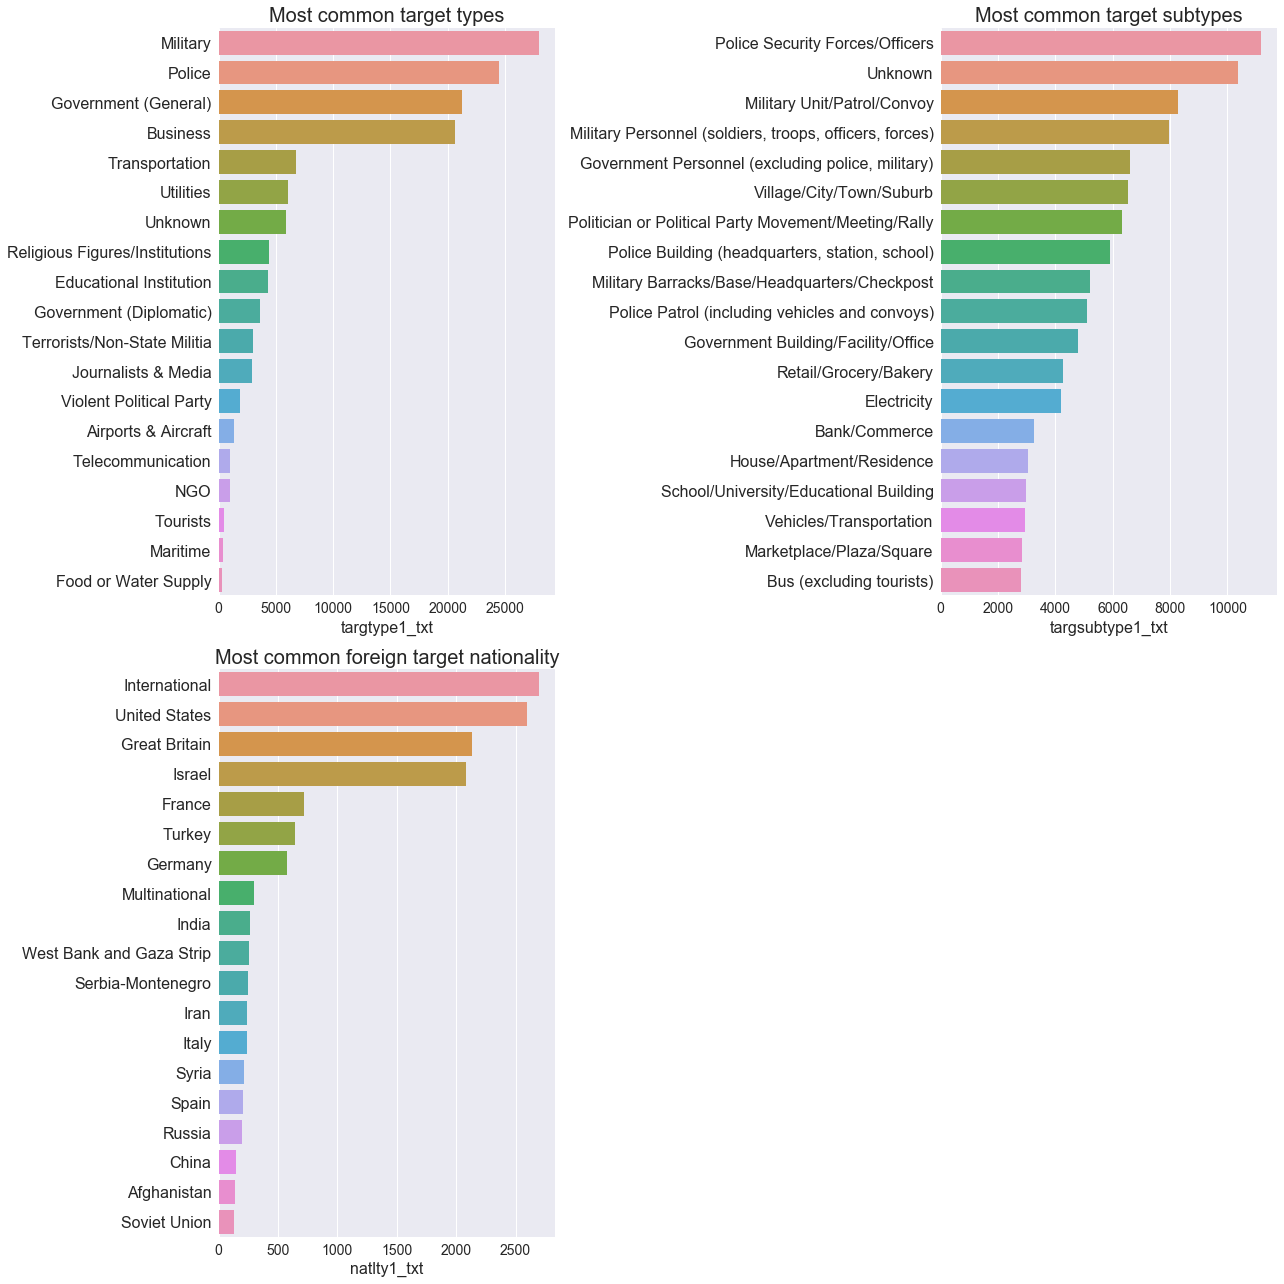

In [111]:
plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.title('Most common target types')
y = gtd_df.targtype1_txt.value_counts().index[1:20]
x = gtd_df.targtype1_txt.value_counts()[1:20]
plt.xlabel('number of attacks')
sns.barplot(x, y)

plt.subplot(222)
plt.title('Most common target subtypes')
y = hyperspecific_df.targsubtype1_txt.value_counts().index[1:20]
x = hyperspecific_df.targsubtype1_txt.value_counts()[1:20]
plt.xlabel('number of attacks')
sns.barplot(x, y)

plt.subplot(223)
plt.title('Most common foreign target nationality')
y = gtd_df[gtd_df.natlty1_txt!=gtd_df.country_txt].natlty1_txt.value_counts().index[1:20]
x = gtd_df[gtd_df.natlty1_txt!=gtd_df.country_txt].natlty1_txt.value_counts()[1:20]
plt.xlabel('number of attacks')
sns.barplot(x, y)

plt.tight_layout()
plt.show()

### Differential plots (attributed vs unattributed)

First let's take a look at the number of casualties vs. whether the incident is attributed to a perpetrating group, and whether it has been publicly claimed by a perpetrating group.

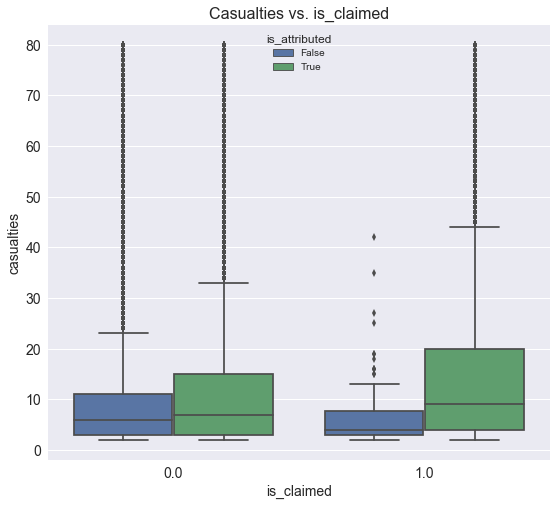

In [135]:
plt.rc('axes', titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

gtd_df['casualties'] = gtd_df.nwound + 3*gtd_df.nkill

plt.figure(figsize=(9,8))
sns.boxplot(gtd_df[gtd_df.casualties.between(2,80)].claimed, 
               gtd_df[gtd_df.casualties.between(2,80)].casualties,
              hue=gtd_df[gtd_df.casualties.between(2,80)].gname!="Unknown")
plt.xlabel('is_claimed')
plt.legend(title='is_attributed')
plt.title("Casualties vs. is_claimed")
plt.show()

gtd_df.drop('casualties', axis=1, inplace=True)

The above plot shows that there is a significant difference between attributed and unattributed attacks: attributed attacks have more casualties.  As the color contrast shows, much of this difference is due to the fact that incidents with higher casualty rates are publicly claimed by the perpetrating group at a higher rate than those with lower casualty rates.

Now let's look at a map version:

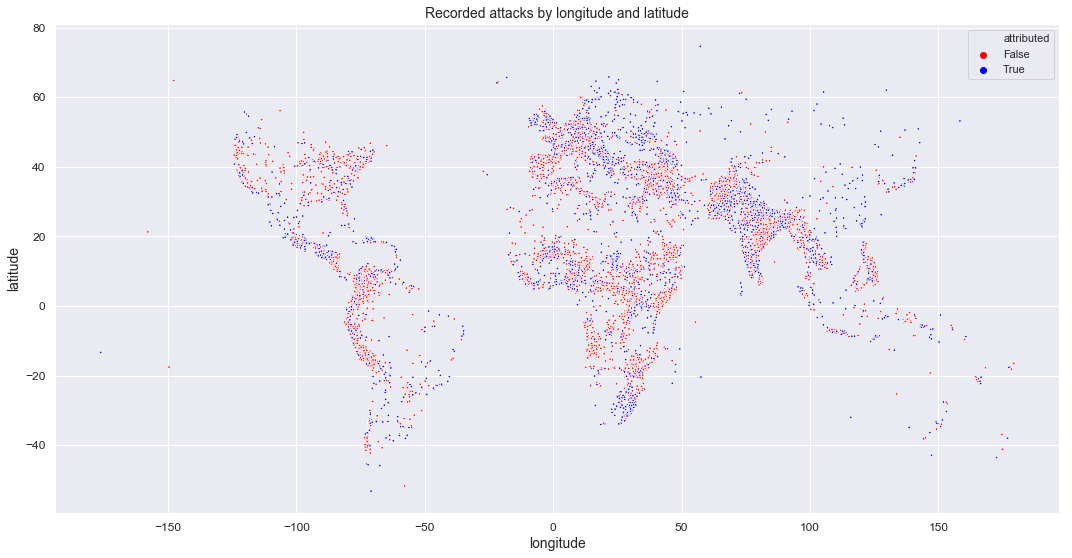

In [68]:
gtd_df['attributed'] = gtd_df.gname=='Unknown'

plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=14)

sns.set_palette('bright')
pal = ['red', 'blue']
plt.figure(figsize=(18,9))
sns.scatterplot(x='longitude', 
            y='latitude',
            data=gtd_df,
            s=6, 
            hue='attributed',
            palette=pal)
plt.title("Recorded attacks by longitude and latitude")
plt.show()
sns.set()

This map confirms the plots above: the Middle East and South Asia show the highest incident density, while North America and northern Asia are relatively sparse.  We can also see that the unattributed attacks seem to have somewhat different distributions that the attributed ones. 

The next plot depicts the largest *differences* in number of attacks of different types, or by different groups, or in different groups, or against different foreign nationalities.  (The nationality of target is almost always the same as the country of the attack; the 'foreign target nationality' subtype shows only cases where the victims are not from the country where the attack took place.)

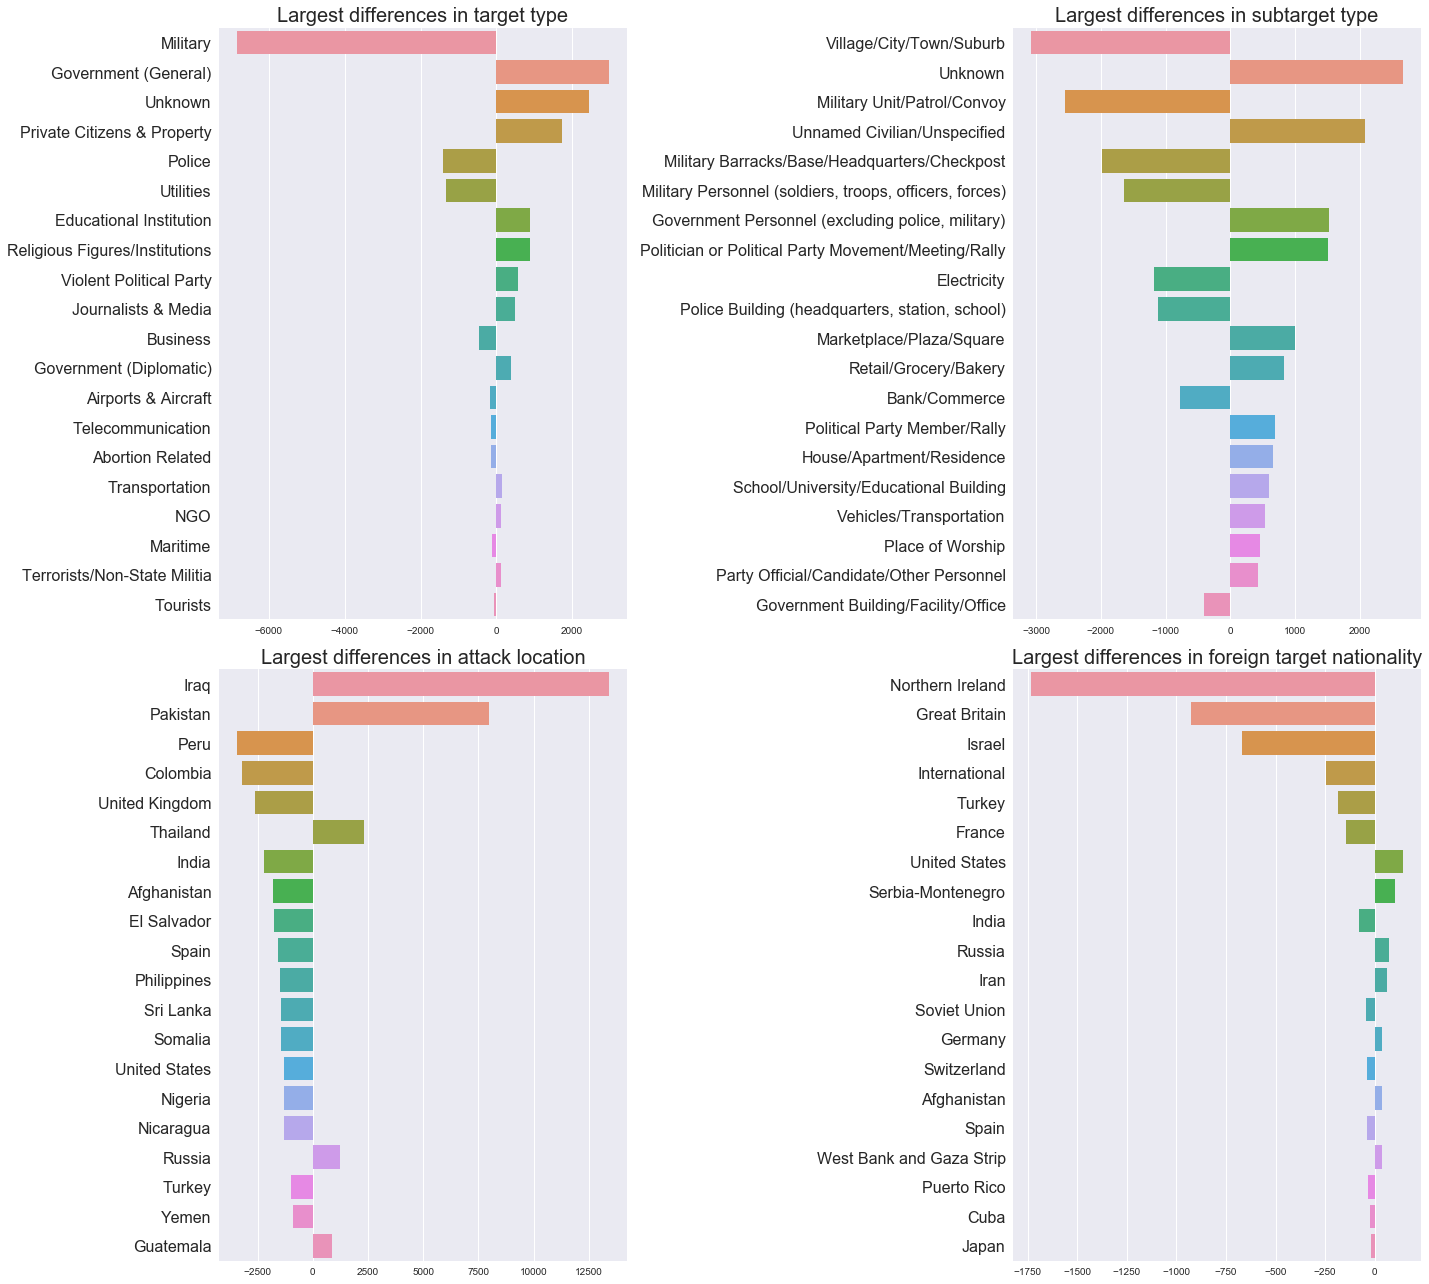

In [31]:
unattr_ratio = sum(gtd_df.gname=='Unknown')/sum(gtd_df.gname!="Unknown")
attributed_df = gtd_df[gtd_df.gname!='Unknown']
unattributed_df = gtd_df[gtd_df.gname=='Unknown']
hyperspecific_attr = hyperspecific_df[hyperspecific_df.gname!='Unknown']
hyperspecific_unattr = hyperspecific_df[hyperspecific_df.gname=='Unknown']

plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(20, 18))

plt.subplot(221)
plt.title('Largest differences in target type')
cat_diff_tups = []
attr_val_counts = attributed_df.sample(frac=unattr_ratio).targtype1_txt.value_counts()
unattr_val_counts = unattributed_df.targtype1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(222)
plt.title('Largest differences in subtarget type')
cat_diff_tups = []
attr_val_counts = hyperspecific_attr.sample(frac=unattr_ratio).targsubtype1_txt.value_counts()
unattr_val_counts = hyperspecific_unattr.targsubtype1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(223)
plt.title('Largest differences in attack location')
cat_diff_tups = []
attr_val_counts = attributed_df.sample(frac=unattr_ratio).country_txt.value_counts()
unattr_val_counts = unattributed_df.country_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(224)
plt.title('Largest differences in foreign target nationality')
cat_diff_tups = []
attr_val_counts = attributed_df[attributed_df.natlty1_txt!=attributed_df.country_txt].sample(frac=unattr_ratio).natlty1_txt.value_counts()
unattr_val_counts = unattributed_df[unattributed_df.natlty1_txt!=unattributed_df.country_txt].natlty1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.tight_layout()
plt.show()

In short, attacks against military or police forces are much less likely to go unattributed.  Attacks against civilians, uncategorized parties, private businesses, or non-military non-police political groups are more likely to go unattributed. This is unsurprising, given that police and military institutions are generally the only organizations equipped with extensive investigatory bodies.  This also explains the difference in foreign target nationalities: these are the countries most likely to have military troops on the ground in foreign nations.

Probably due to extensive military presence as well as high overall rates, Iraq and Pakistan have by far the highest differential in favor of attributed incidents.

Overall, these stats show that to get optimal prediction over the unattributed incidents, we may need to oversample our dataset in favor of attacks NOT against military or police forces, and NOT in Iraq or Pakistan.  However, if we split or segment our data by country at the top of our hierarchical classification model, we would only need to do this for training the model that makes the first split.  We may need to oversample generally for type of target, if we don't segment the data by that feature as well.

# Feature engineering



In [141]:
non_domestic_target = [gtd_df.natlty1_txt[i] if gtd_df.natlty1_txt[i] != gtd_df.country_txt[i] else np.nan \
    for i in range(len(gtd_df.natlty1_txt))]

gtd_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=True)
gtd_prepped_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=True)
gtd_filled_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=False)

### Pseudocode for further engineered features:

In [ ]:
# # NAIVE BAYES HYPERSPECIFIC
# split full data WITH hyperspecific columns into train and test sets
# for each hyperspecific_col:
#     - make dataframe of dummies from that column's features
#     - train a multinomialNB on the training portion of that dataframe
#     - get multinomialNB predictions and probabilities for train and test portions of the dataframe
#     - append those predictions and probabilities to the full train and test sets as two new columns
# - To test, fit a classifier on that train set, predict on the test set, and compare results to 
# - the results of that classifier without these two added features

# # BERNOULLI BINARIES:
# - train one BernoulliNB model on a test split of all binary cols in gtd_filled
# - append BernoulliNB predictions and probabilities to the train and test splits of the full dataset
#    - test by fitting a classifier on the training set with the Bernoulli_pred and Bernoulli_prob added,
#    - getting predictions for train and test set, and comparing results to the same train/test split results
#    - without the Bernoulli additions
    
# # NAIVE BAYES GAUSSIAN:
# # (we could also break this down further to Poisson and Gaussian)
# - same as Bernoulli procedure above, but run on all the real-number features instead

# # TEXTUAL FEATURES:
# retool custom function (in parent directory) add_best_words.py to work for multiclass instances
# (this function uses a formula based on Bayes' Theorem to select and add binary word-features for
# the n words that best differentiate target classes)
# add 10-20 best_words per text column

## CITY EXTERNAL DATA:
# - import gdp and gdp/capita by year and country from gdp_data.csv and gdp_per_cap_data.csv
# - find a spreadsheet with majority religion and govt type; import and merge
# - merge into main dataframe

### Feature reduction with GLRM:

Because we have many features, we may want a feature reduction algorithm to allow for more complex clustering algorithms that would be unfeasible on a 70+ feature dataset with 100,000 examples. We also want this featureset to be null-less so we can use sklearn and other non-null-handling libraries.  This algorithm should ideally be able to handle different types of data, including numerical, binary, and categorical.

Probably the best single algorithm that can fulfill all of these needs is Generalized Low-Rank Models. GLRM uses alternating minimization with customizable-by-column cost functions to allow for a PCA- or NNMF-like matrix factorization across various data types. The reduced dataset is null-less and lower-rank than the original. We'll try this here with the number of reduced features set to 30.

#### General-purpose GLRM:

In [168]:
# Load the H2O library and start up the H2O cluster locally on my machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,19 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 20 days
H2O cluster name:,garrettfiddler
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [169]:
glrmodel_20 = H2OGeneralizedLowRankEstimator(
                                       k=20,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [164]:
# note: using gtd_prepped_df rather than the full gtd_df here
# because the latter creates a strange nullPointerException in Java 
type_conversions = {
    np.dtype('float64'):'real',
    np.dtype('int64'):'int',
    np.dtype('bool'):'enum',
    np.dtype('object'):'enum',
}

glrm_column_types = {}
coltypes = gtd_filled_df.drop('gname', axis=1).dtypes
for col in gtd_filled_df.drop('gname', axis=1).columns:
    glrm_column_types[col] = type_conversions[coltypes[col]]

In [170]:
gtd_h2 = h2o.H2OFrame(gtd_filled_df.drop('gname', axis=1), column_types=glrm_column_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [171]:
start = time()
glrmodel_20.train(training_frame=gtd_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 21.8 minutes


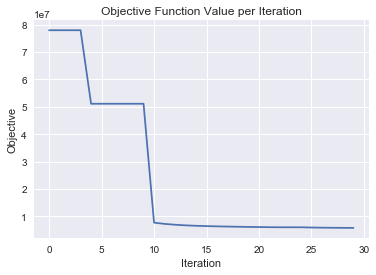

In [172]:
model_score = glrmodel_20.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [173]:
model = glrmodel_20._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_20_df = X.as_data_frame()

print('Projected shape:', glrm_20_df.shape)

Projected shape: (181685, 20)


In [174]:
glrm_20_df.to_csv('glrm_20.csv')

#### GLRM for visualization:

In [159]:
glrmodel_vis = H2OGeneralizedLowRankEstimator(
                                       k=2,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       impute_original=True)

In [160]:
# note: used gtd_prepped_df for this one
start = time()
glrmodel_vis.train(training_frame=gtd_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 3.0 minutes


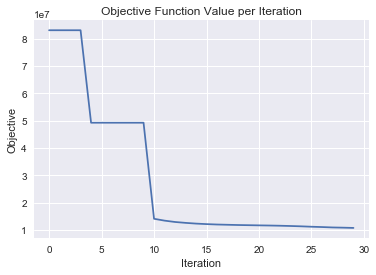

In [161]:
model_score = glrmodel_vis.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [162]:
model = glrmodel_vis._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_vis_df = X.as_data_frame()

print('Projected shape:', glrm_vis_df.shape)

Projected shape: (181685, 2)


In [166]:
glrm_vis_df.to_csv('glrm_vis.csv')

### Clustering

In [ ]:
# models = 
#     k-means
#     Ward agglomerative
#     HDBSCAN # may work best based on *dense* lines in glrm_vis plot

# for each model:
#     for each useful parameter set (if specifying k, try for a couple tiers):
#         use glrm_20 to cluster
#         glrm_vis features to plot
#         use custom function show_silhouettes to plot silhouette scores

# Initial model trials

Before we start building a hierarchical classification model, it makes sense to try flat classification just as a benchmark.  Given the computational expenses of running it for 3K target classes, we'll first try in on subsets of just the most prolific groups.  This will also give us a run-up to our first model (#1), the frequency-based segmentation classifier.

In [4]:
from time import time
from sklearn.model_selection import train_test_split
import warnings

def quick_test_model(model, X_set, y):
    # NOTE: I'm using accuracy as the sole metric here because it's the same as either micro or macro f1-score
    # for cases where every example belongs to one and only one category
    
    warnings.filterwarnings(action='ignore', category=DeprecationWarning) # arises with current lightGBM + numpy
    
    start = time()
    X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=1/3)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = round(sum(y_pred_train==y_train)/len(y_train), 3)
    test_accuracy = round(sum(y_pred_test==y_test)/len(y_test), 3)
    
    print("  train accuracy:", train_accuracy)
    print("  test accuracy:", test_accuracy)
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')

In [42]:
dummy_df = pd.get_dummies(gtd_filled_df.drop('gname', axis=1))
dummy_df = pd.concat([dummy_df, gtd_df.gname], axis=1)
dummy_df.shape

(181685, 428)

In [86]:
next_groups = dummy_df.gname.value_counts()[1:21].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_20 = next_df.gname
X_20_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[1:101].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_100 = next_df.gname
X_100_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[101:201].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_200 = next_df.gname
X_200_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[201:301].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_300 = next_df.gname
X_300_df = next_df.drop('gname', axis=1)

In [91]:
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize

gnbc = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=5, weights='distance')
dtc = DecisionTreeClassifier()
lgbmc = LGBMClassifier(class_weight='balanced')

print("PREDICTING 20 MOST PROLIFIC GROUPS:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_20_df, y_20)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_20_df, y_20)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_20_df, y_20)
print("\nLightGBM:")
quick_test_model(lgbmc, X_20_df, y_20)

print("\nPREDICTING 100 MOST PROLIFIC GROUPS:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_100_df, y_100)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_100_df, y_100)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_100_df, y_100)
print("\nLightGBM:")
quick_test_model(lgbmc, X_100_df, y_100)

print("\nPREDICTING GROUPS 100-200:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_200_df, y_200)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_200_df, y_200)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_200_df, y_200)
print("\nLightGBM:")
quick_test_model(lgbmc, X_200_df, y_200)

print("\nPREDICTING GROUPS 200-300:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_300_df, y_300)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_300_df, y_300)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_300_df, y_300)
print("\nLightGBM:")
quick_test_model(lgbmc, X_300_df, y_300)

PREDICTING 20 MOST PROLIFIC GROUPS:

Gaussian Naive Bayes:
  train accuracy: 0.144
  test accuracy: 0.141
elapsed time: 0.1 minutes

K-neighbors classifier:
  train accuracy: 1.0
  test accuracy: 0.499
elapsed time: 0.2 minutes

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.98
elapsed time: 0.0 minutes

LightGBM:
  train accuracy: 0.998
  test accuracy: 0.987
elapsed time: 0.4 minutes

PREDICTING 100 MOST PROLIFIC GROUPS:

Gaussian Naive Bayes:
  train accuracy: 0.143
  test accuracy: 0.141
elapsed time: 0.7 minutes

K-neighbors classifier:
  train accuracy: 1.0
  test accuracy: 0.434
elapsed time: 0.4 minutes

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.921
elapsed time: 0.1 minutes

LightGBM:
  train accuracy: 0.995
  test accuracy: 0.938
elapsed time: 2.6 minutes

PREDICTING GROUPS 100-200:

Gaussian Naive Bayes:
  train accuracy: 0.145
  test accuracy: 0.142
elapsed time: 0.1 minutes

K-neighbors classifier:
  train accuracy: 1.0
  test a

As anticipated, LightGBM performs the best on all of these data segments.  Somewhat to my surprise, the simplistic decision tree, while being exponentially faster, is also very nearly as accurate.  These results accord nicely with a hierarchical understanding of the data.

As a benchmark, let's try both of these fairly successful models as flat classifiers on a couple version of the full dataset:
- the entire dataset
- all non-singleton attacks (eliminates 48% of the class labels at the cost of discarding 1.7% of the data)
- all non-singleton-or-dual attacks (eliminates 62% of the class labels at the cost of discarding 2.7% of the data)

In [108]:
next_groups = dummy_df.gname.value_counts()[1:1827].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_non_single = next_df.gname
X_non_single = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[1:1345].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_non_dual = next_df.gname
X_non_dual = next_df.drop('gname', axis=1)

next_df = dummy_df[dummy_df.gname!='Unknown']
y_full = next_df.gname
X_full = next_df.drop('gname', axis=1)

In [109]:
print("PREDICTING OVER FULL DATASET (3536 classes):")
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_full, y_full)
print("\nLightGBM:")
quick_test_model(lgbmc, X_full, y_full)

print("\nPREDICTING OVER NON SINGLETONS (1825 classes):")
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_non_single, y_non_single)
print("\nLightGBM:")
quick_test_model(lgbmc, X_non_single, y_non_single)

print("\nPREDICTING OVER NON SINGLETONS OR DUALS(1343 classes):")
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_non_dual, y_non_dual)
print("\nLightGBM:")
quick_test_model(lgbmc, X_non_dual, y_non_dual)


PREDICTING OVER FULL DATASET:

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.818
elapsed time: 0.3 minutes

LightGBM:
  train accuracy: 0.005
  test accuracy: 0.005
elapsed time: 26.1 minutes

PREDICTING OVER NON SINGLETONS:

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.821
elapsed time: 0.2 minutes

LightGBM:
  train accuracy: 0.033
  test accuracy: 0.03
elapsed time: 18.4 minutes

PREDICTING OVER NON SINGLETONS OR DUALS:

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.798
elapsed time: 0.5 minutes

LightGBM:
  train accuracy: 0.057
  test accuracy: 0.059
elapsed time: 44.3 minutes


*Note: the above results are mislabeled; the order above is actually 1) non-single -- 2) non-dual -- 3) full*

This is very interesting: LightGBM outperforms a decision tree when the number of classes is only around a hundred, even when the number of examples per class is small, but its accuracy plummets (and its runtime balloons) when the number of classes expands to over a thousand.  The basic decision tree, on the other hand, is a little less accurate on the limited-number-of-classes case, but its accuracy stays strong even with thousands of classes.  In the case of the entire dataset (3536 classes), it still achieves nearly 80% accuracy and only take 30 seconds to run.  

We may be able to achieve some of the accuracy of the decision tree in lightGBM by building fewer, but much larger, trees.  However, given the success of decision trees, for now our go-to model for many-class prediction will be decision trees.  (For fewer-class prediction we may still want to use lightGBM.)

*Note: for a more detailed look at the lightGBM accuracy delay, see appendix at bottom of notebook*

### A different look at Naive Bayes
Before moving forward, I want to take a quick second look at Naive Bayes. As we saw above, the Gaussian NB didn't perform very well for us.  This makes sense, since our data has mixed distribution types and non-independent features. It should perform better with the GLRM-reduced features because they're more normally distributed and almost entirely independent.

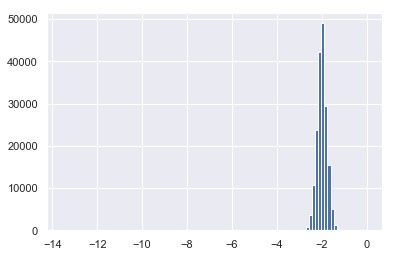

In [47]:
plt.hist(glrm_20_df.Arch1*10, bins=100);

In [58]:
# glrm_20_df = pd.read_csv('glrm_20.csv', index_col=0)
glrm_20_df['gname'] = gtd_df.gname

from sklearn.naive_bayes import GaussianNB

next_groups = glrm_20_df.gname.value_counts()[1:101].index
next_df = glrm_20_df[glrm_20_df.gname.isin(next_groups)]
X_temp_df = pd.get_dummies(next_df.drop('gname', axis=1))
y = next_df.gname
# priors = [y.value_counts()[val]/len(y) for val in y.value_counts().index]

gnbc = GaussianNB()
quick_test_model(gnbc, X_temp_df, y)
glrm_20_df.drop('gname', axis=1, inplace=True)

  train accuracy: 0.249
  test accuracy: 0.252
elapsed time: 0.0 minutes


This is several times better, but still not very good.  What we really want is to use different distribution-assumptions for different features - and ideally, handle the categorical features directly, which is quite possible for Naive Bayes (but sklearn doesn't support categoricals).

Below is a custom categorical-handling Naive Bayes package I wrote for this project.  It only handles categorical features right now, since those are the ones sklearn can't handle.  However, it could be combined with existing packages to make the ideal mixed-type Naive Bayes classifier.  (This package also handles nulls without issue.)

In [9]:
from catNB import CatNB
from sklearn.model_selection import train_test_split
from time import time

next_groups = gtd_df.gname.value_counts()[1:21].index
next_df = gtd_df.select_dtypes('object')[gtd_df.gname.isin(next_groups)]
y_temp = next_df.gname
X_temp_df = next_df.drop('gname', axis=1)

cnbc = CatNB()

quick_test_model(cnbc, X_temp_df, y_temp)

  train accuracy: 0.967
  test accuracy: 0.933
elapsed time: 1.1 minutes


In [10]:
from catNB import CatNB

next_groups = gtd_df.gname.value_counts()[1:101].index
next_df = gtd_df.select_dtypes('object')[gtd_df.gname.isin(next_groups)]
y_temp = next_df.gname
X_temp_df = next_df.drop('gname', axis=1)

cnbc = CatNB()
quick_test_model(cnbc, X_temp_df, y_temp)

  train accuracy: 0.388
  test accuracy: 0.3
elapsed time: 7.7 minutes


This classifier works quite well for the top 20 groups - almost as well as LightGBM running on ALL the features (keep in mind that catNB is running exclusively on the categorical features here).  However, when the dataset is expanded to the top 100 groups, the accuracy plummets, whereas LightGBM holds its accuracy pretty well until it gets into the 100+ range, and decision trees hold their accuracy across the entire dataset.  So categoricalNB may be helpful as a boosting feature, but probably not as a predictive model itself (unless perhaps combined with a GaussianNB model for the numerical data).

It's worth noting, however, that this custom package significantly outperformed the GaussianNB (even on the more normally-distributed GLRM data) while using only half the available data (it didn't use any of the numerical features).  This proves its usefulness as a tool, even if it's not the best solution for this many-classed problem.

# Hierarchical classification ensembles

### 1. Frequency-based segmented classification

In [153]:
print("Top 100 groups account for {} percent of attacks".format(
    round( sum(gtd_df.gname.value_counts()[1:101])/sum(gtd_df.gname.value_counts()[1:])*100, 1) )
     )
    
print("Top 200 groups account for {} percent of attacks".format(
    round( sum(gtd_df.gname.value_counts()[1:201])/sum(gtd_df.gname.value_counts()[1:])*100, 1) )
     )

Top 100 groups account for 76.4 percent of attacks
Top 200 groups account for 84.8 percent of attacks


In [170]:
def is_in_prolif_range(start, end, df=gtd_prepped_df):
    top_n = df.gname.value_counts().index[start:end]
    return df.gname.isin(top_n)
    
# top_20 = gtd_prepped_df.gname.value_counts().index[1:21]
# is_top_20 = gtd_prepped_df.gname.isin(top_20)
# next_30 = gtd_df.gname.value_counts().index[21:51]
# is_next_30 = gtd_df.gname.isin(next_30)

print("Predictive accuracy for whether attack is by one of the top n most prolific groups:")
    
print("\nTop 20:")
quick_test_model(LGBMClassifier(class_weight='balanced'), X_df, is_in_prolif_range(1,21))

print("\nTop 50:")
quick_test_model(LGBMClassifier(class_weight='balanced'), X_df, is_in_prolif_range(1,51))

print("\nTop 100:")
quick_test_model(LGBMClassifier(class_weight='balanced'), X_df, is_in_prolif_range(1,101))

print("\nTop 200:")
quick_test_model(LGBMClassifier(class_weight='balanced'), X_df, is_in_prolif_range(1,201))

print("\nTop 200 (but not top 50):")
quick_test_model(LGBMClassifier(class_weight='balanced'), X_df, is_in_prolif_range(51,201))

Predictive accuracy for whether attack is by one of the top n most prolific groups:

Top 20:
  train accuracy: 0.964
  test accuracy: 0.962
elapsed time: 0.3 minutes

Top 50:
  train accuracy: 0.947
  test accuracy: 0.944
elapsed time: 0.3 minutes

Top 100:
  train accuracy: 0.94
  test accuracy: 0.937
elapsed time: 0.3 minutes

Top 200:
  train accuracy: 0.935
  test accuracy: 0.932
elapsed time: 0.3 minutes

Top 200 (but not top 50):
  train accuracy: 0.881
  test accuracy: 0.879
elapsed time: 0.3 minutes


Here's what we learned from these tests:
- we can predict the top 100 groups (with an oversimplified model) at 94% segmenting * 93% classification = 87.5% accuracy.
- the top 100 groups account for 76% of the data
- after the top 100 groups, as attacks per group falls below 100, the predictive accuracy quickly plummets

It looks like we can easily clear 90% on the top 100 with better parameters.  Further segmenting, above and below 100, can probably get us to something near 80% total accuracy (more with our fancier engineered features).  This isn't bad, but it isn't as good as we'd like.

It's probably time to move on and give ideas #2, #3, and #4 a spin.  But first, a quick look at Naive Bayes:

### 2. Feature-based segmented classification

In [ ]:
# eliminate singletons
# split by region
# predict

# Conclusions

This challenge took more time than I was able to fit in before the deadline!  More results to come.

# Appendix

Some non-trivial material whose use:space ratio didn't warrant inclusion above

### 1. Further lightGBM tests across frequency segments

In [166]:
from lightgbm import LGBMClassifier

interval_tuples = [
    (1, 21),
    (101, 121),
    (1, 101),
    (1, 201),
    (201, 501),
    (201, 1001),
    (1, 1001)
]

for tup in interval_tuples:
    lgbmc_basic_params = {  # geared to make this fast and suited for multiclass
        'class_weights':'balanced', 
        'objective':'multiclass', 
        'metric':'multi_logloss', 
        'num_class':tup[1]-tup[0],
        'n_estimators':20,
        'min_data_in_leaf':20}
    
    next_groups = gtd_df.gname.value_counts()[tup[0]:tup[1]].index
    total_attacks = sum(gtd_df.gname.value_counts()[tup[0]:tup[1]])
    mean_attacks_per_group = int(round(np.mean(gtd_df.gname.value_counts()[tup[0]:tup[1]])))
    med_attacks_per_group = int(np.median(gtd_df.gname.value_counts()[tup[0]:tup[1]]))
    min_per_group = gtd_df.gname.value_counts()[tup[1]]
    max_per_group = gtd_df.gname.value_counts()[tup[0]]

    next_df = gtd_prepped_df[gtd_prepped_df.gname.isin(next_groups)]
    X_temp_df = pd.get_dummies(next_df.drop('gname', axis=1))
    y = next_df.gname

    lgbmc = LGBMClassifier(**lgbmc_basic_params)
    # Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    print("\nPrediction over groups #{}-{}:\n  (total attacks = {}; mean = {}; min·median·max = {}·{}·{})".format(
        tup[0], 
        tup[1]-1, 
        total_attacks,
        mean_attacks_per_group,
        min_per_group,
        med_attacks_per_group,
        max_per_group))
    quick_test_model(lgbmc, X_temp_df, y)


Prediction over groups #1-20:
  (total attacks = 51092; mean = 2555; min·median·max = 830·2167·7477)
  train accuracy: 0.99
  test accuracy: 0.985
elapsed time: 0.1 minutes

Prediction over groups #101-120:
  (total attacks = 2377; mean = 119; min·median·max = 102·118·136)
  train accuracy: 0.992
  test accuracy: 0.968
elapsed time: 0.0 minutes

Prediction over groups #1-100:
  (total attacks = 75524; mean = 755; min·median·max = 136·311·7477)
  train accuracy: 0.977
  test accuracy: 0.934
elapsed time: 0.7 minutes

Prediction over groups #1-200:
  (total attacks = 83826; mean = 419; min·median·max = 53·137·7477)
  train accuracy: 0.201
  test accuracy: 0.203
elapsed time: 1.6 minutes

Prediction over groups #201-500:
  (total attacks = 7801; mean = 26; min·median·max = 13·22·53)
  train accuracy: 0.179
  test accuracy: 0.148
elapsed time: 0.4 minutes

Prediction over groups #201-1000:
  (total attacks = 11297; mean = 14; min·median·max = 4·9·53)
  train accuracy: 0.066
  test accurac

# Works cited
I found several helpful sites and papers on this subject.  Unfortunately, I've only yet had time to skim them, so most of what you see above is based on my own intuition, and I'm sure there's much I could revise and add based on closer reads of these sources and others.
- <a href="http://www.johnsnowlabs.com/dataops-blog/hierarchical-classification-a-useful-approach-when-predicting-thousands-of-possible-categories/">Chaves, Pedro. "Hierarchical classification – a usefula pproach when predicting thousands of possible categoris".</a>  A useful conceptual overview of the subject.
- <a href="https://www.researchgate.net/publication/228580843_A_Tutorial_on_Hierarchical_Classification_with_Applications_in_Bioinformatics">Freitas and Carvalho, 2007.  "A Tutorial on Hierarchical Classification with Applications in Bioinformatics"</a> An accessible if outdated overview/tutorial of the subject.
- <a href="https://cs.gmu.edu/~mlbio/presentation_SDM.pdf"> Rangwala and Naik, 2016. "Large Scale Hierarchical Classification: Foundations,
Algorithms and Applications"</a> Presentation slides with some helpful visualizations.
- <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.183.302&rep=rep1&type=pdf"> Freitas and Silla, Jr. "A Survey of Hierarchical Classification Across Different Application Domains"</a> An overview and taxonomy of the subject.
- <a href="https://www.researchgate.net/publication/268445148_Terrorist_Group_Prediction_Using_Data_Classification"> Gohar, Faryal & Haider, Wasi & Qamar, Usman & Publications, SDIWC. (2014). "Terrorist Group Prediction Using Data Classification".</a> Discovered in the 11th hour, this source features a non-hierarchical ensemble classifier that achieved 6.64% error rate over the labeled data in this dataset.




# Scratch -- ignore

In [125]:
test_df = pd.DataFrame()
test_df['a'] = [1,2,3,4]
test_df['b'] = [5,6,7,8]
test_df['c'] = [1,2,'s','t']
d = {'a':5}
d2 = {'b':6}
test_df['d'] = [5,2,d2,d2]
test_df

,a,b,c,d
0,1,5,1,5
1,2,6,2,2
2,3,7,s,{'b': 6}
3,4,8,t,{'b': 6}


In [300]:
# show countries with null latitudes:
gtd_filled_df[gtd_filled_df.longitude.isnull()].gname.isnull().sum()

0

In [271]:
# search for country:
countries = np.unique([c for c in gtd_df.country_txt.values if "Cocos" in c])
gtd_df.country_txt.value_counts()[countries]

Series([], Name: country_txt, dtype: int64)

In [48]:
# show remaining null counts after filling everything but long/lat:
nulls = gtd_filled_df.isnull().sum()
for col in gtd_filled_df.columns:
    if nulls[col] > 0:
        print(col, nulls[col])

latitude 4550
longitude 4551


In [ ]:
# CORE COLUMNS - most likely to be determinative of the group responsible
core_cols = [
    'iyear'
    'country_txt'
    'city'
    'latitude'
    'longitude'
    'suicide'
    'natlty1_txt'
    'attacktype1'
    'targtype1_txt'
    'targsubtype1_txt'
    'weaptype1_txt'
    'weapsubtype1_txt'
    'ishostkid'
    'nhostkid'
    'INT_LOG'
    'INT_IDEO'
    'INT_MISC'
]